In [1]:
# prepare 
import numpy as np
import pylab as pb
import GPy as gpy
import matplotlib
from matplotlib import pyplot as plt
from numpy.linalg import inv
from IPython.display import display
from scipy.fftpack import fft, ifft
from numpy import linalg as LA
pb.ion()
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)

C:\Users\Ruoxi\Anaconda\lib\site-packages\GPy\util\linalg.py:48: UserWarning: warning: caught this exception:function 'dsyrk_' not found
  warnings.warn("warning: caught this exception:" + str(e))


## kron_mvprod(As,b) 
Gilboa et al, $(\bigotimes_{d=1}^DA_d)b = vec([A_1 ...[A_{D-1}[A_DB]^T]^T]^T)$, where b is a vector

Here we implement "Algorithm 2" in Gilboa et al with minor modifications. 
We make b to be a matrix, whose columns are different samples with the purpose to draw thousands of samples simutanously. 


In [2]:
def kron_mvprod2(As,b):
    x = b
    for d in np.arange(len(As)-1,-1,-1):
        Gd = As[d].shape[0]
        N = x.size
        X = np.matrix(x.reshape(Gd,N/Gd,order='F'))
        Z = As[d]*X
        Z = Z.T
        x = Z.reshape(Z.size/b.shape[1],b.shape[1],order='F') 
       
    out = x.reshape(1,x.size,order='F') 
    out = out.reshape(x.size/b.shape[1],b.shape[1],order='C') 
    return out;

In [4]:
# test
A1 =  np.matrix([[1, 2], [3, 4]])
A2 =  np.matrix([[5,6,7], [8,9,10],[11,12,13]])
A3 =  np.matrix([[5,2], [6,4]])
As = [A1,A2,A3]
b = np.random.random((12,3))*10

# confirm kron_mvprod2
out1 =  kron_mvprod2(As,b)
out2 = np.kron(A1,np.kron(A2,A3)) * np.matrix(b) 
out1-out2 #close to zero

matrix([[  0.00000000e+00,  -2.27373675e-13,   0.00000000e+00],
        [  4.54747351e-13,   4.54747351e-13,  -4.54747351e-13],
        [ -4.54747351e-13,   0.00000000e+00,   0.00000000e+00],
        [  4.54747351e-13,   4.54747351e-13,   0.00000000e+00],
        [ -9.09494702e-13,   0.00000000e+00,   0.00000000e+00],
        [ -9.09494702e-13,   0.00000000e+00,   0.00000000e+00],
        [ -4.54747351e-13,   0.00000000e+00,   0.00000000e+00],
        [  9.09494702e-13,   0.00000000e+00,  -9.09494702e-13],
        [ -9.09494702e-13,   0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,  -1.81898940e-12],
        [ -9.09494702e-13,  -9.09494702e-13,  -1.81898940e-12],
        [ -1.81898940e-12,   1.81898940e-12,   0.00000000e+00]])

## Generate Data

In [5]:
# generate data

# number of samples
n = np.arange(0,5,1)[np.newaxis].transpose() 

# time
fs = 5.0  #  time step:1/fs
t = np.arange(0,5,1/fs)[np.newaxis].transpose()
t.size

# number of cancer types
c = np.arange(0,6,1)[np.newaxis].transpose() 
float(t.size * c.size-1)

149.0

In [6]:
# Given covariance matrix 
# Requirement: tr(sigma_N) = tr(sigma_T) = tr(sigma_C)

# sigma_N: covariance along N
k1 = gpy.kern.RBF(1, variance=0.2, lengthscale=1)
cov_N = k1.K(n) #given covariance, ground truth
sigma_N = cov_N * float(t.size * c.size-1)
print np.matrix.trace(sigma_N)

# sigma_T: covariance along T
k2 = gpy.kern.RBF(1, variance=0.2 * n.size * float(t.size * c.size-1)/(t.size*float(n.size*c.size-1)), lengthscale=2)
cov_T = k2.K(t) #given covariance, ground truth
sigma_T = cov_T * float(n.size*c.size-1)
print np.matrix.trace(sigma_T)

# sigma_C: covariance along C
k3 = gpy.kern.RBF(1, variance=0.2 * n.size * float(t.size * c.size-1)/(c.size*float(t.size*n.size-1)), lengthscale=1)
cov_C = k3.K(c) #given covariance, ground truth
sigma_C = cov_C * float(t.size*n.size-1)
print np.matrix.trace(sigma_C)

149.0
149.0
149.0


In [11]:
# Infer U,V,W
U = sigma_N/np.matrix.trace(sigma_N) *np.matrix.trace(sigma_N)
V = sigma_T/np.matrix.trace(sigma_N) 
W = sigma_C/np.matrix.trace(sigma_N) 

## GP-trick

$W \sim N(0,I_{NCT})$

$W \in R^{NCT}$

$Z = LW \sim N(0,\Sigma)$, where $\Sigma = QVQ^T$

$L = QV^{1/2}$

$Z = QV^{1/2}W \sim  N(0,\Sigma)$

$Z = (Q_1 \otimes Q_2 \otimes Q_3 ... \otimes Q_P)( V_1^{1/2} \otimes V_2^{1/2} \otimes V_3^{1/2} ... \otimes V_P^{1/2})W$




In [41]:
x_N = 0 # estimate of sigma_N
x_T = 0 # estimate of sigma_T
x_C = 0 # estimate of sigma_C

# record error history: sum of absolute difference of every element
dataN = [None] * Ndraws
dataT = [None] * Ndraws
dataC = [None] * Ndraws

# record error history: max difference 
dataN2 = [None] * Ndraws
dataT2 = [None] * Ndraws
dataC2 = [None] * Ndraws

for j in xrange(0, Ndraws-1):
    
    x=np.array(rand[:,j])
    #x = np.random.multivariate_normal(np.zeros(t.size*n.size*c.size), covariance, 1)
    
    # reshape
    z = x.reshape(c.size,n.size,t.size)
    
    # cancer type (c), # of samples (n), time (t) 
    
    # covariance along cancer c
    nn = float(c.size)
    a = z[0,:,:].ravel()
    # flatten t, n axis
    for i in np.arange(1,nn):
        a = np.vstack((a, z[i,:,:].ravel()))
    x_C = x_C + np.cov(a)
    # record error
    dataC[np.int(j)] = sum(sum(np.absolute(cov_C - x_C/np.int(j+1))))
    dataC2[np.int(j)] = np.max(cov_C - x_C/np.int(j+1)).real
 
   # covariance along number of samples n
    nn = float(n.size)
    b = z[:,0,:].ravel()
    # flatten t, c axis
    for i in np.arange(1,nn):
        b = np.vstack((b, z[:,i,:].ravel()))
    x_N = x_N + np.cov(b)
    # record error
    dataN[np.int(j)] = sum(sum(np.absolute(cov_N - x_N/np.int(j+1))))
    dataN2[np.int(j)] = np.max(cov_N - x_N/np.int(j+1)).real
    
    # covariance along time (t)
    nn = float(t.size)
    d = z[:,:,0].ravel()
    # flatten n, c axis
    for i in np.arange(1,nn):
        d = np.vstack((d, z[:,:,i].ravel()))
    x_T = x_T + np.cov(d)
    # record error 
    dataT[np.int(j)] = sum(sum(np.absolute(cov_T - x_T/np.int(j+1))))
    dataT2[np.int(j)] = np.max(cov_T - x_T/np.int(j+1)).real
     
x_N = x_N/Ndraws
x_T = x_T/Ndraws
x_C = x_C/Ndraws

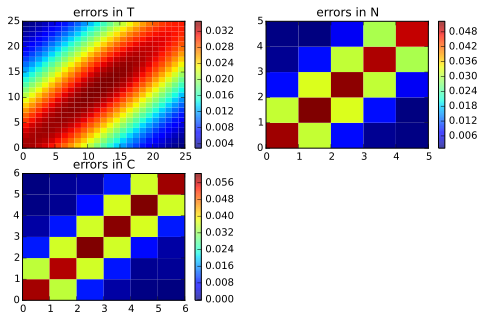

In [42]:
#plot results

plt.subplot(2, 2, 1)
# caovariance in T
data = cov_T - x_T
plt.pcolor(data.real)
plt.colorbar() 
plt.title('errors in T')

plt.subplot(2, 2, 2)
# caovariance in N
data = cov_N - x_N
plt.pcolor(data.real)
plt.colorbar() 
plt.title('errors in N') 

plt.subplot(2, 2, 3)
# covariance in C
data = cov_C - x_C
plt.pcolor(data.real)
plt.colorbar() 
plt.title('errors in C') 

plt.show()

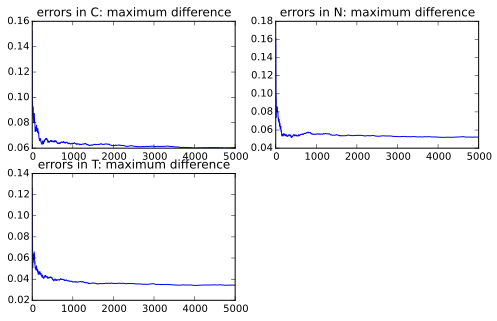

In [43]:
# error plot: maximum difference
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, Ndraws, Ndraws),dataC2)
plt.title('errors in C: maximum difference')
plt.subplot(2, 2, 2)
plt.plot(np.linspace(0, Ndraws, Ndraws),dataN2)
plt.title('errors in N: maximum difference')
plt.subplot(2, 2, 3)
plt.plot(np.linspace(0, Ndraws,Ndraws),dataT2)
plt.title('errors in T: maximum difference')

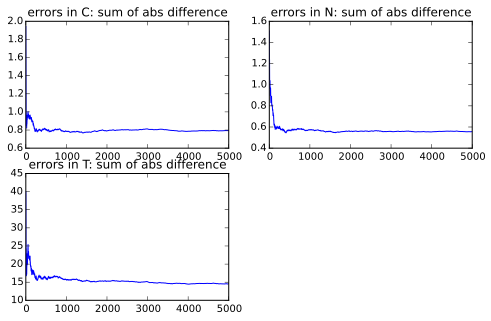

In [44]:
# error plot: sum of abs difference
plt.subplot(2, 2, 1)
plt.plot(np.linspace(0, Ndraws, Ndraws),dataC)
plt.title('errors in C: sum of abs difference')
plt.subplot(2, 2, 2)
plt.plot(np.linspace(0, Ndraws, Ndraws),dataN)
plt.title('errors in N: sum of abs difference')
plt.subplot(2, 2, 3)
plt.plot(np.linspace(0, Ndraws,Ndraws),dataT)
plt.title('errors in T: sum of abs difference')